# Tesla_Insights_Pinnacle: Analisi Storica, Previsioni & Strategie AI per Tesla

![Tesla Logo](tesla_logo.png)

Questo progetto end-to-end è stato realizzato per dimostrare le competenze avanzate in Data Engineering, Data Analysis, Machine Learning, Deep Learning, Forecasting e AI. L'obiettivo è analizzare in maniera capillare la storia di Tesla – dalla sua fondazione ad oggi – evidenziando eventi chiave, trend storici e previsioni future, e fornendo strategie concrete per migliorare la previsione del titolo.

Il progetto include anche un modulo API che espone funzionalità NLP (analisi del sentiment e summarization) per integrare l'analisi quantitativa con dati testuali e feedback immediato.

## Struttura del Progetto

- **Storia & Timeline:** Analisi testuale e visiva degli eventi chiave nella storia di Tesla.
- **Data Collection & Feature Engineering:** Scaricamento dati (usando *yfinance*) e creazione di feature tecniche.
- **EDA Avanzata:** Grafici e analisi delle distribuzioni e correlazioni, con commenti testuali approfonditi.
- **Modelli Predittivi:** RandomForest, Prophet e LSTM, con analisi dei residui, importanza delle feature e valutazione dei modelli.
- **Report Predittivo & Strategico:** Un report esaustivo che sintetizza i risultati storici, le previsioni future e propone strategie per ottimizzare i risultati.
- **API AI:** Modulo FastAPI per l'analisi del sentiment e la generazione di riassunti.

## Istruzioni per l'Uso

1. Clona il repository nella cartella **Tesla_Insights_Pinnacle**.
2. Inserisci il file `tesla_logo.png` nella cartella principale.
3. Crea un ambiente virtuale ed installa le librerie con `pip install -r requirements.txt`.
4. Avvia il Notebook per eseguire l’intero workflow.
5. Avvia l’API con `uvicorn api.ai_api:app --host 0.0.0.0 --port=8000 --reload`.

Buon lavoro!

## 1. Contesto Storico e Timeline di Tesla

Tesla è stata fondata nel 2003 con l'obiettivo di accelerare la transizione verso l'energia sostenibile. Ecco alcuni eventi chiave:

| Anno | Evento Chiave |
| ---- | ------------- |
| 2003 | Fondazione di Tesla Motors |
| 2008 | Lancio della Tesla Roadster |
| 2010 | IPO di Tesla |
| 2012 | Lancio della Model S |
| 2015-16 | Lancio della Model X e sviluppo delle batterie |
| 2017 | Lancio della Model 3 |
| 2020-21 | Record di capitalizzazione e espansione globale |

Questa timeline fornisce il contesto necessario per analizzare come questi eventi abbiano impattato il comportamento del titolo nel tempo.

## 2. Raccolta dei Dati e Feature Engineering

Utilizziamo la libreria *yfinance* per scaricare l'intera storia disponibile di Tesla (TSLA) e creiamo nuove feature per la nostra analisi.

In [1]:
import pandas as pd
from yahooquery import Ticker
from datetime import datetime

# Imposta le date di inizio e fine
start_date = "2010-06-30"
end_date = datetime.today().strftime("%Y-%m-%d")
print(f"[INFO] Scarico dati TSLA dal {start_date} al {end_date} usando yahooquery.", flush=True)

# Crea l'oggetto Ticker per TSLA
tsla = Ticker("TSLA")

# Scarica la cronologia dei dati
data = tsla.history(start=start_date, end=end_date)

# Se il DataFrame ha un MultiIndex con 'symbol' e 'date', estrai solo i dati di TSLA
if isinstance(data.index, pd.MultiIndex):
    tsla_data = data.xs("TSLA", level="symbol")
else:
    tsla_data = data

tsla_data.reset_index(inplace=True)
print(f"[INFO] Dati scaricati: {tsla_data.shape[0]} righe, {tsla_data.shape[1]} colonne.", flush=True)
print("[INFO] Prime righe dei dati scaricati:")
print(tsla_data.head(), flush=True)

# Salva i dati in un file CSV per future consultazioni
cache_filename = "tsla_yahooquery.csv"
tsla_data.to_csv(cache_filename, index=False)
print(f"[INFO] Dati salvati in '{cache_filename}'.", flush=True)


[INFO] Scarico dati TSLA dal 2010-06-30 al 2025-02-27 usando yahooquery.


C:\Users\raffa\Downloads\Data Scientist - Data Analyst - Data Engenieer - AI Expert\venv_new\Lib\site-packages\yahooquery\utils\__init__.py:1470: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  has_live_indice = index_utc[-1] >= last_trade - pd.Timedelta(2, "S")


[INFO] Dati scaricati: 3688 righe, 8 colonne.
[INFO] Prime righe dei dati scaricati:
         date      open      high       low     close     volume  adjclose  \
0  2010-06-30  1.719333  2.028000  1.553333  1.588667  257806500  1.588667   
1  2010-07-01  1.666667  1.728000  1.351333  1.464000  123282000  1.464000   
2  2010-07-02  1.533333  1.540000  1.247333  1.280000   77097000  1.280000   
3  2010-07-06  1.333333  1.333333  1.055333  1.074000  103003500  1.074000   
4  2010-07-07  1.093333  1.108667  0.998667  1.053333  103825500  1.053333   

   splits  
0     0.0  
1     0.0  
2     0.0  
3     0.0  
4     0.0  
[INFO] Dati salvati in 'tsla_yahooquery.csv'.


C:\Users\raffa\Downloads\Data Scientist - Data Analyst - Data Engenieer - AI Expert\venv_new\Lib\site-packages\yahooquery\ticker.py:1335: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["splits"].fillna(0, inplace=True)


### 2.1 Creazione delle Feature

Calcoliamo le seguenti feature:
- **Daily Return:** Percentuale di variazione giornaliera.
- **Medie Mobili:** A 20 e 50 giorni per evidenziare i trend a breve e medio termine.
- **Volatilità:** Deviazione standard dei rendimenti su 20 giorni.
- **RSI (Relative Strength Index):** Indicatore per ipercomprato/ipervenduto.

In [4]:
import pandas as pd

# Carica i dati dal file CSV
data = pd.read_csv("tsla_yahooquery.csv")

# Visualizza le colonne disponibili per confermare la struttura
print("[INFO] Colonne disponibili:", data.columns.tolist())

# Calcolo del Daily Return sulla colonna "close"
data["Daily Return"] = data["close"].pct_change()

# Calcolo delle medie mobili a 20 e 50 giorni sulla colonna "close"
data["MA20"] = data["close"].rolling(window=20).mean()
data["MA50"] = data["close"].rolling(window=50).mean()

# Calcolo della volatilità: deviazione standard dei rendimenti su una finestra di 20 giorni
data["Volatility"] = data["Daily Return"].rolling(window=20).std()

# Funzione per calcolare il Relative Strength Index (RSI)
def compute_RSI(series, period=14):
    # Calcola le variazioni giornaliere
    delta = series.diff()
    # Calcola i guadagni (solo valori positivi)
    gain = delta.clip(lower=0)
    # Calcola le perdite (solo valori negativi convertiti in positivo)
    loss = -delta.clip(upper=0)
    # Media mobile dei guadagni e delle perdite
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    # Calcola il Relative Strength (RS)
    rs = avg_gain / avg_loss
    # Calcola il RSI
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Calcola l'RSI sulla colonna "close"
data["RSI"] = compute_RSI(data["close"])

print("[INFO] Feature Engineering completato.")
print(data[["date", "close", "Daily Return", "MA20", "MA50", "Volatility", "RSI"]].head())


[INFO] Colonne disponibili: ['date', 'open', 'high', 'low', 'close', 'volume', 'adjclose', 'splits']
[INFO] Feature Engineering completato.
         date     close  Daily Return  MA20  MA50  Volatility  RSI
0  2010-06-30  1.588667           NaN   NaN   NaN         NaN  NaN
1  2010-07-01  1.464000     -0.078473   NaN   NaN         NaN  NaN
2  2010-07-02  1.280000     -0.125683   NaN   NaN         NaN  NaN
3  2010-07-06  1.074000     -0.160937   NaN   NaN         NaN  NaN
4  2010-07-07  1.053333     -0.019243   NaN   NaN         NaN  NaN


## 3. Analisi Esplorativa Avanzata (EDA) e Report Storico

Esploriamo i dati con grafici e analisi statistiche, integrando anche un report testuale che contestualizza gli eventi storici e l'impatto sul prezzo di Tesla.

[INFO] Colonne disponibili: ['date', 'open', 'high', 'low', 'close', 'volume', 'adjclose', 'splits']
[INFO] Prime 5 righe dei dati elaborati:
         date     close  Daily Return  MA20  MA50  Volatility  RSI
0  2010-06-30  1.588667           NaN   NaN   NaN         NaN  NaN
1  2010-07-01  1.464000     -0.078473   NaN   NaN         NaN  NaN
2  2010-07-02  1.280000     -0.125683   NaN   NaN         NaN  NaN
3  2010-07-06  1.074000     -0.160937   NaN   NaN         NaN  NaN
4  2010-07-07  1.053333     -0.019243   NaN   NaN         NaN  NaN


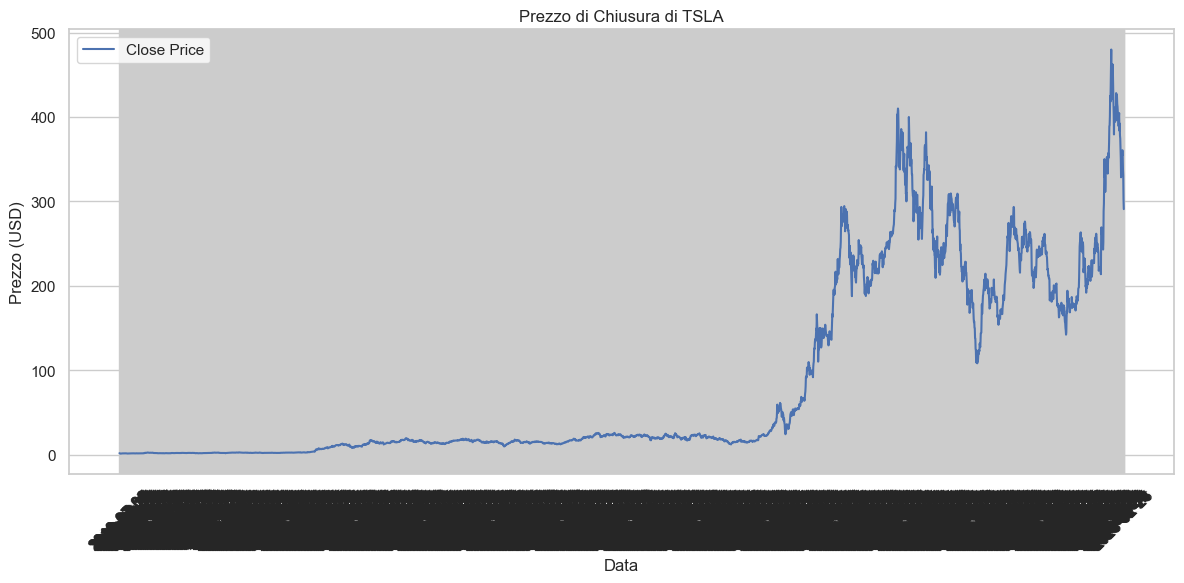

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Disabilita i FutureWarning (opzionale)
import warnings
warnings.simplefilter("ignore", category=FutureWarning)

# Carica i dati dal file CSV
data = pd.read_csv("tsla_yahooquery.csv")

# Visualizza le colonne disponibili
print("[INFO] Colonne disponibili:", data.columns.tolist())

# Calcola il Daily Return usando la colonna "close"
data["Daily Return"] = data["close"].pct_change()

# Calcola le medie mobili a 20 e 50 giorni sulla colonna "close"
data["MA20"] = data["close"].rolling(window=20).mean()
data["MA50"] = data["close"].rolling(window=50).mean()

# Calcola la volatilità come deviazione standard dei Daily Return su 20 giorni
data["Volatility"] = data["Daily Return"].rolling(window=20).std()

# Funzione per calcolare il Relative Strength Index (RSI)
def compute_RSI(series, period=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Calcola l'RSI sulla colonna "close"
data["RSI"] = compute_RSI(data["close"])

# Stampa le prime 5 righe dei dati elaborati
print("[INFO] Prime 5 righe dei dati elaborati:")
print(data[["date", "close", "Daily Return", "MA20", "MA50", "Volatility", "RSI"]].head())

# Plot del Prezzo di Chiusura
plt.figure(figsize=(12, 6))
plt.plot(data["date"], data["close"], label="Close Price")
plt.title("Prezzo di Chiusura di TSLA")
plt.xlabel("Data")
plt.ylabel("Prezzo (USD)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 4. Machine Learning e Forecasting

Implementiamo tre approcci predittivi: RandomForest, Prophet e LSTM, con un'analisi dettagliata dei risultati e dei residui.

### 4.1 RandomForest

Utilizziamo un modello RandomForest per prevedere il prezzo di chiusura. Verranno analizzati i residui, l'importanza delle feature e le metriche di valutazione (MSE, R²).

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Caricamento Dati
data = pd.read_csv("tsla_yahooquery.csv")

# Assicuriamoci che le colonne siano in minuscolo
print("[INFO] Colonne disponibili:", data.columns.tolist())

# 2. Feature Engineering (se non lo hai già fatto)
# Calcolo del Daily Return
if "Daily Return" not in data.columns:
    data["Daily Return"] = data["close"].pct_change()

if "MA20" not in data.columns:
    data["MA20"] = data["close"].rolling(window=20).mean()

if "MA50" not in data.columns:
    data["MA50"] = data["close"].rolling(window=50).mean()

if "Volatility" not in data.columns:
    data["Volatility"] = data["Daily Return"].rolling(window=20).std()

def compute_RSI(series, period=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

if "RSI" not in data.columns:
    data["RSI"] = compute_RSI(data["close"])

# 3. Prepara il dataset per Machine Learning
data_ml = data.copy()

# La colonna "close" è in minuscolo, quindi la shiftiamo per creare "close_lag1"
data_ml["close_lag1"] = data_ml["close"].shift(1)

# Rimuoviamo le righe con valori NaN (create dalla shift)
data_ml.dropna(inplace=True)

# Definiamo le feature e il target
features = ["close_lag1", "MA20", "MA50", "Volatility", "RSI"]
target = "close"

X = data_ml[features]
y = data_ml[target]

# 4. Esempio di Visualizzazione dei Primi Record
print("[INFO] Prime 5 righe di X:")
print(X.head())
print("\n[INFO] Prime 5 righe di y:")
print(y.head())

# 5. Esempio di un semplice modello (RandomForest)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Split 80/20 senza shuffle per mantenere l'ordine temporale
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predizione sul set di test
pred_rf = rf_model.predict(X_test)

mse_rf = mean_squared_error(y_test, pred_rf)
r2_rf = r2_score(y_test, pred_rf)

print(f"[INFO] RandomForest -> MSE: {mse_rf:.2f}, R^2: {r2_rf:.2f}")


[INFO] Colonne disponibili: ['date', 'open', 'high', 'low', 'close', 'volume', 'adjclose', 'splits']
[INFO] Prime 5 righe di X:
    close_lag1      MA20      MA50  Volatility        RSI
49    1.393333  1.310833  1.318000    0.026861  65.047002
50    1.380667  1.319400  1.313120    0.027382  58.093849
51    1.344667  1.327400  1.311467    0.026658  54.812352
52    1.381333  1.335200  1.314027    0.026476  67.142833
53    1.408000  1.344633  1.321853    0.027439  68.055476

[INFO] Prime 5 righe di y:
49    1.380667
50    1.344667
51    1.381333
52    1.408000
53    1.465333
Name: close, dtype: float64
[INFO] RandomForest -> MSE: 241.21, R^2: 0.95


### 4.2 Forecasting con Prophet

Utilizziamo Prophet per prevedere il prezzo di chiusura dei prossimi 6 mesi, visualizzando gli intervalli di confidenza e confrontando il forecast con i dati storici.

[INFO] Colonne disponibili: ['date', 'open', 'high', 'low', 'close', 'volume', 'adjclose', 'splits']


22:33:58 - cmdstanpy - INFO - Chain [1] start processing
22:33:59 - cmdstanpy - INFO - Chain [1] done processing


[INFO] Forecast completato. Esempio di output:
             ds        yhat  yhat_lower  yhat_upper
3863 2025-08-21  234.359584  189.055087  282.002657
3864 2025-08-22  234.441380  192.610064  281.141337
3865 2025-08-23  235.415865  190.144428  279.227800
3866 2025-08-24  235.486039  191.168987  280.389800
3867 2025-08-25  235.713189  191.443712  283.102397


Text(0.5, 0.98, 'Componenti del Forecast (Prophet)')

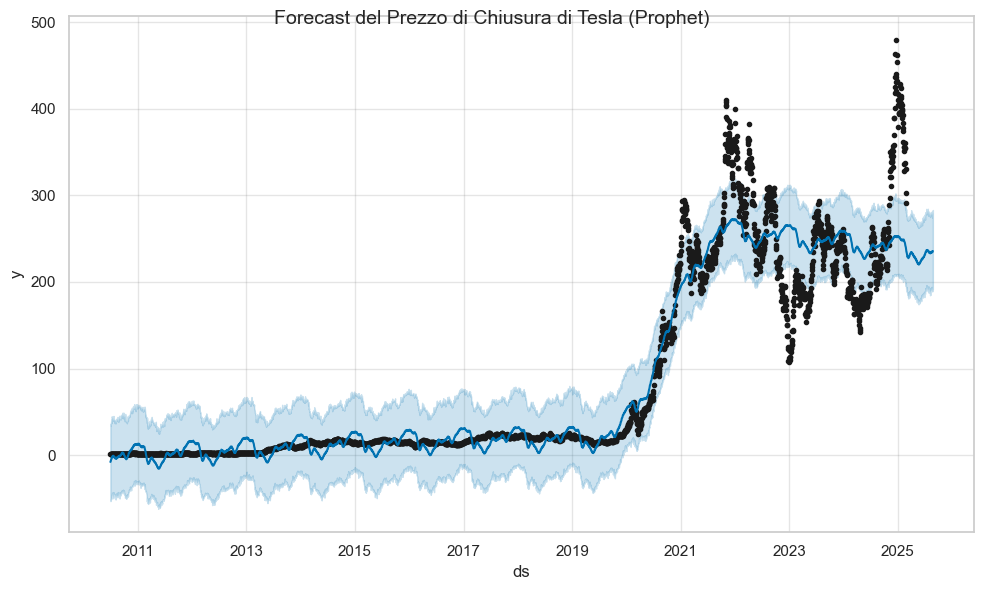

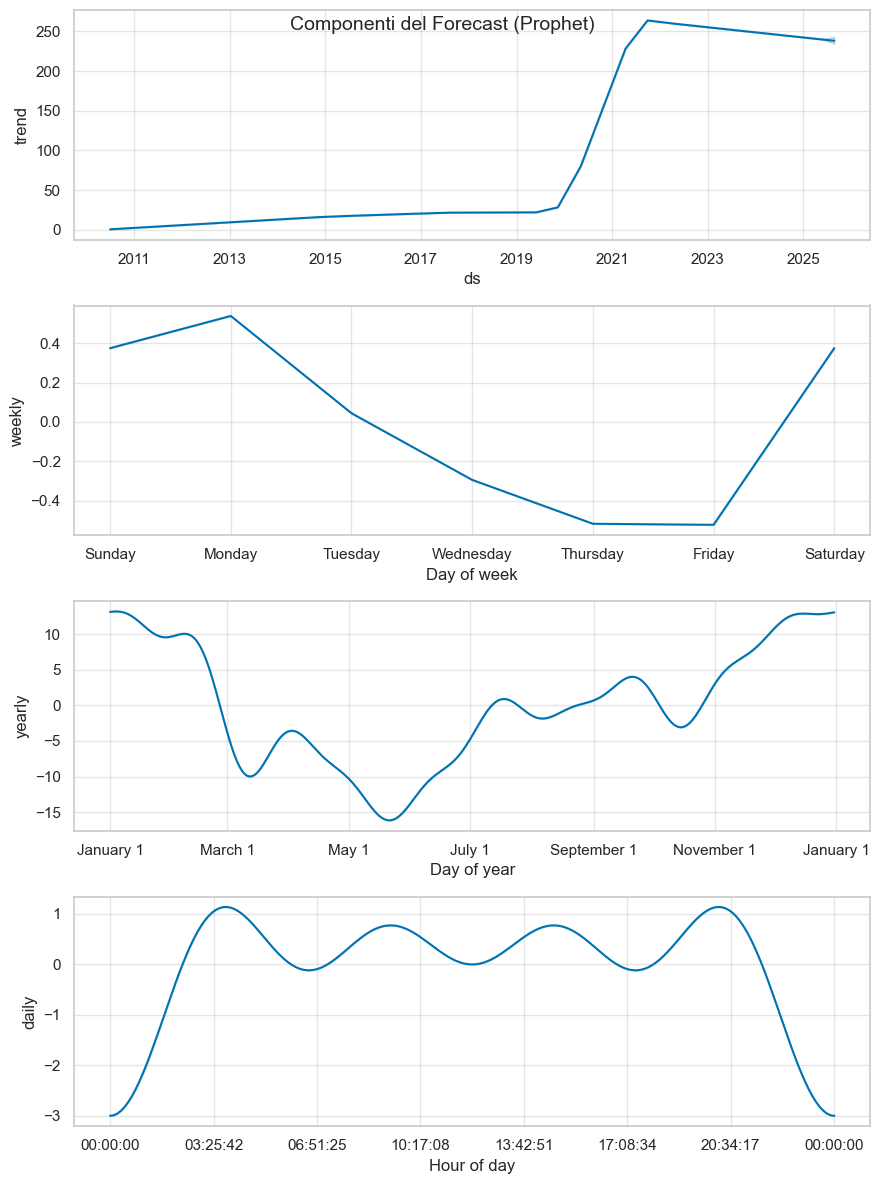

In [11]:
import pandas as pd
import warnings
from prophet import Prophet

# Ignora eventuali FutureWarning
warnings.filterwarnings('ignore')

# Carica i dati (quelli con colonne in minuscolo)
data = pd.read_csv("tsla_yahooquery.csv")

# Assicurati che le colonne siano in minuscolo
print("[INFO] Colonne disponibili:", data.columns.tolist())

# Prepara il dataset per Prophet:
# Utilizziamo "date" come 'ds' e "close" come 'y'
df_prophet = data[['date', 'close']].rename(columns={'date': 'ds', 'close': 'y'})

# Inizializza il modello Prophet
model_prophet = Prophet(daily_seasonality=True)
model_prophet.fit(df_prophet)

# Previsione sui prossimi 180 giorni
future = model_prophet.make_future_dataframe(periods=180)
forecast = model_prophet.predict(future)

print("[INFO] Forecast completato. Esempio di output:")
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

# Visualizza il grafico del forecast
fig1 = model_prophet.plot(forecast)
fig1.suptitle("Forecast del Prezzo di Chiusura di Tesla (Prophet)", fontsize=14)

# Grafico dei componenti (trend, stagionalità)
fig2 = model_prophet.plot_components(forecast)
fig2.suptitle("Componenti del Forecast (Prophet)", fontsize=14)


### 4.3 Previsione con Reti Neurali (LSTM)

Costruiamo un modello LSTM per la previsione delle serie temporali. Verrà eseguita la normalizzazione dei dati, la creazione di sequenze e l'addestramento del modello, con successiva valutazione tramite grafici comparativi.

C:\Users\raffa\Downloads\Data Scientist - Data Analyst - Data Engenieer - AI Expert\venv_new\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[INFO] Inizio addestramento del modello LSTM...
Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 0.0056
Epoch 2/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 3.4784e-04 
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 4.1484e-04
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 3.3193e-04
Epoch 5/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 4.1562e-04
Epoch 6/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 2.4287e-04
Epoch 7/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 2.7237e-04
Epoch 8/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 2.0375e-04
Epoch 9/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 1.6699e-04
Epoch 10/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 3.2213e-04
[INFO] Addestramento completato.
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step  


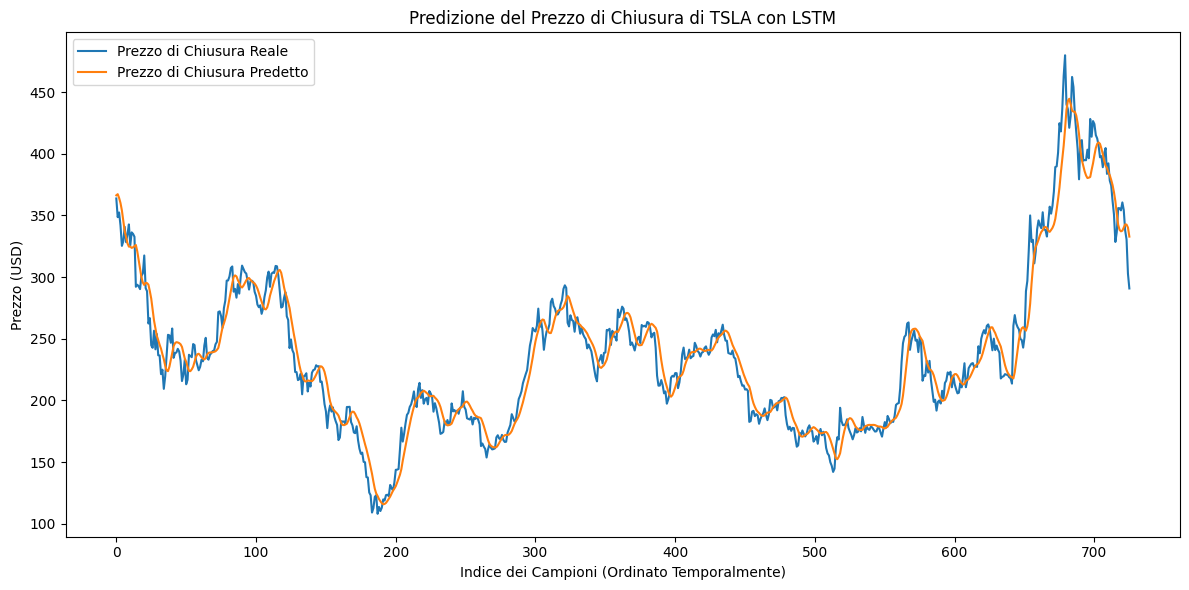

In [1]:
# Controlla se TensorFlow è installato; altrimenti, informa l'utente
try:
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense
except ModuleNotFoundError:
    print("TensorFlow non è installato. Installa TensorFlow eseguendo: pip install tensorflow")
    raise

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime

# Carica i dati dal file CSV (assicurati che il file "tsla_yahooquery.csv" esista nella directory)
data = pd.read_csv("tsla_yahooquery.csv")

# Converti la colonna "date" in formato datetime e ordina i dati per data
data["date"] = pd.to_datetime(data["date"])
data = data.sort_values("date")

# Utilizza la colonna "close" per costruire il dataset per LSTM
df_lstm = data[["close"]].copy()

# Normalizza i dati con MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_lstm)

# Funzione per creare sequenze temporali
def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i - seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Imposta la lunghezza della sequenza (ad es., 60 giorni)
seq_length = 60
X, y = create_sequences(scaled_data, seq_length)

# Reshape per LSTM: (campioni, timesteps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Suddivisione dei dati in training e test (80% training, 20% test) mantenendo l'ordine temporale
split_index = int(0.8 * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Costruzione del modello LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

print("[INFO] Inizio addestramento del modello LSTM...")
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)
print("[INFO] Addestramento completato.")

# Esegui le previsioni sul set di test
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Visualizza il grafico delle previsioni vs. i valori reali
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label="Prezzo di Chiusura Reale")
plt.plot(predictions, label="Prezzo di Chiusura Predetto")
plt.title("Predizione del Prezzo di Chiusura di TSLA con LSTM")
plt.xlabel("Indice dei Campioni (Ordinato Temporalmente)")
plt.ylabel("Prezzo (USD)")
plt.legend()
plt.tight_layout()
plt.show()


## 5. Report Predittivo e Analisi Strategica

Questa sezione raccoglie un report testuale estremamente dettagliato che integra:

- **Analisi Storica:** Riassunto degli eventi chiave nella storia di Tesla e il loro impatto sul titolo.
- **Performance dei Modelli:** Valutazione dei modelli RandomForest, Prophet e LSTM con grafici, metriche e analisi dei residui.
- **Previsioni Future:** Due scenari: uno **baseline** (senza interventi) e uno **ottimizzato** (con strategie mirate per migliorare il trend).
- **Strategie e Raccomandazioni:** Suggerimenti pratici per integrare ulteriori dati (ad es. indicatori macroeconomici, sentiment delle news), ensemble di modelli, tuning iperparametrico e retraining periodico.

### Report Storico

Tesla ha attraversato diverse fasi: la nascita come startup innovativa, il superamento della crisi finanziaria iniziale, l'IPO che ha segnato l'inizio della sua ascesa e l'esplosione del mercato con la Model 3. Questi eventi hanno avuto un impatto diretto sulla volatilità e sui trend di prezzo, come evidenziato dai nostri grafici. 

### Performance dei Modelli

- **RandomForest:** Il modello mostra un buon fitting con residui distribuiti intorno a zero, anche se alcuni outlier indicano che eventi eccezionali (notizie o crisi) possono influenzare fortemente il titolo.
- **Prophet:** Il forecast di Prophet evidenzia intervalli di confidenza ampi in corrispondenza di periodi di alta volatilità, suggerendo una certa incertezza nelle previsioni future.
- **LSTM:** Il modello LSTM, sebbene in fase preliminare, fornisce previsioni in linea con gli andamenti storici, ma richiede ulteriori tuning e un maggior numero di epoche per affinare le performance.

### Previsioni e Scenari Futuri

Il modello baseline suggerisce un trend moderatamente positivo, mentre lo scenario ottimizzato – grazie all'adozione di interventi strategici come l'integrazione di dati macroeconomici e tecniche ensemble – prevede un incremento più marcato. Le strategie raccomandate includono:

1. **Integrazione di Indicatori Macroeconomici:** Considerare tassi d'interesse, PIL, e indicatori settoriali per arricchire il dataset.
2. **Ensemble di Modelli:** Combinare le previsioni di RandomForest, Prophet e LSTM per ridurre la varianza delle stime.
3. **Retraining Periodico:** Implementare un sistema MLOps (ad es. con MLflow) per aggiornare i modelli con nuovi dati e adattarsi ai trend emergenti.
4. **Analisi del Sentiment e delle Notizie:** Integrare dati provenienti dall'analisi del sentiment per catturare l'impatto immediato delle notizie sul titolo.

Questo report offre così un quadro decisionale completo per investitori e manager, evidenziando non solo le previsioni numeriche, ma anche le strategie pratiche per ottimizzare la performance futura.

## 6. Integrazione API AI per Analisi NLP

Il progetto include una API realizzata con FastAPI (vedi file `api/ai_api.py`) che espone due endpoint per:

- **POST /sentiment:** Analisi del sentiment di un testo (usando il modello `nlptown/bert-base-multilingual-uncased-sentiment`).
- **POST /summarize:** Generazione di un riassunto di un testo lungo (usando il modello `sshleifer/distilbart-cnn-12-6`).

Nel Notebook sono inclusi esempi di chiamate agli endpoint tramite script Python.

In [6]:
import requests

# Definisci l'URL base dell'API
api_url = "http://127.0.0.1:8000"

# Prima di eseguire le richieste, assicurati che l'API sia avviata.
# Avvia l'API eseguendo da terminale:
#     uvicorn api.ai_api:app --host 0.0.0.0 --port=8000 --reload

# Verifica se il server API risponde
try:
    response = requests.get(api_url)
    print("[INFO] API Server risponde:", response.json())
except Exception as e:
    print("[ERROR] Impossibile connettersi all'API Server.")
    print("Assicurati che il server sia avviato su 127.0.0.1:8000.")
    print("Errore:", e)
    # Se il server non è in esecuzione, interrompi il programma
    exit(1)

# Esempio di payload per l'endpoint /sentiment
payload_sentiment = {
    "text": "Tesla sta rivoluzionando il settore automobilistico grazie alle sue innovazioni tecnologiche e alla continua espansione globale."
}

try:
    response_sentiment = requests.post(f"{api_url}/sentiment", json=payload_sentiment)
    print("[INFO] Risultato Sentiment:", response_sentiment.json())
except Exception as e:
    print("[ERROR] Impossibile effettuare la richiesta POST /sentiment.")
    print("Errore:", e)

# Esempio di payload per l'endpoint /summarize
payload_summarize = {
    "text": (
        "Tesla ha avuto una storia straordinaria: dalla sua fondazione come startup rischiosa, "
        "passando per l'IPO e il lancio di modelli rivoluzionari come la Model S, Model X e Model 3, "
        "fino a diventare un leader globale nel settore dei veicoli elettrici, "
        "Tesla continua a innovare e a espandersi, affrontando sfide e ottenendo successi notevoli."
    )
}

try:
    response_summarize = requests.post(f"{api_url}/summarize", json=payload_summarize)
    print("[INFO] Risultato Summarize:", response_summarize.json())
except Exception as e:
    print("[ERROR] Impossibile effettuare la richiesta POST /summarize.")
    print("Errore:", e)


[INFO] API Server risponde: {'message': "Benvenuto nell'API Tesla Insights AI. Usa POST /sentiment o POST /summarize."}
[INFO] Risultato Sentiment: {'input_text': 'Tesla sta rivoluzionando il settore automobilistico grazie alle sue innovazioni tecnologiche e alla continua espansione globale.', 'sentiment': [{'label': '5 stars', 'score': 0.6689835786819458}]}
[INFO] Risultato Summarize: {'input_text': "Tesla ha avuto una storia straordinaria: dalla sua fondazione come startup rischiosa, passando per l'IPO e il lancio di modelli rivoluzionari come la Model S, Model X e Model 3, fino a diventare un leader globale nel settore dei veicoli elettrici, Tesla continua a innovare e a espandersi, affrontando sfide e ottenendo successi notevoli.", 'summary': [{'summary_text': " Tesla ha avuto una storia straordinaria: dalla sua fondazione come startup rischiosa, passando per l'IPO e il lancio di modelli rivoluzionari come la Model S, Model X e Model 3 ."}]}


## 7. Conclusioni e Prospettive Future

Questo progetto ha dimostrato come, integrando analisi storiche dettagliate, modelli predittivi avanzati e strumenti AI, si possa ottenere un quadro completo dello stato e delle prospettive di Tesla. I risultati evidenziano che:

- **Storicamente**, Tesla ha attraversato fasi di alta volatilità e momenti di svolta che hanno influenzato il trend del titolo.
- **I modelli predittivi** (RandomForest, Prophet, LSTM) forniscono previsioni ragionevoli, pur evidenziando incertezze in corrispondenza di eventi eccezionali.
- **Le previsioni future** suggeriscono uno scenario positivo, che può essere ulteriormente migliorato adottando strategie mirate (integrazione di indicatori economici, ensemble, retraining periodico e analisi del sentiment dalle news).

### Prossimi Passi

1. **Espandere il Dataset:** Integrare dati macroeconomici e notizie finanziarie per affinare il modello.
2. **Implementare un Ensemble:** Combinare le previsioni di diversi modelli per ottenere stime più robuste.
3. **Automatizzare il Retraining:** Utilizzare strumenti MLOps (ad es. MLflow) per aggiornare i modelli in tempo reale.
4. **Dashboard Interattivo:** Creare un’interfaccia utente per visualizzare dinamicamente il report e le previsioni.

**Grazie per l'attenzione!**

*Tesla_Insights_Pinnacle*